### Importing the libararies

In [2]:
import os

In [ ]:
os.chdir('..')
os.listdir()

In [4]:
#hide
!pip install -Uqq fastbook
import fastbook
#fastbook.setup_book()

In [5]:
from fastbook import *

In [6]:
from fastai.vision.all import *

### Dataloder, to load images from folder

In [8]:
dls=ImageDataLoaders.from_folder(path='crack-detection/crack_data/ForLoader/train/',bs=4,valid_pct=0.2)

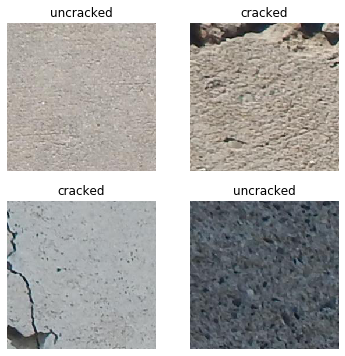

In [9]:
dls.show_batch()

### Here comes the real magic of fastai: Learner and DataBLocks,
* Here we will define learner, and we have not to worry about the last layers of pretrained models, it will take care of it, also it chooses the loss for us, and there are some other benefits that come with it.

In [10]:
learn = cnn_learner(dls, vgg16_bn, metrics=error_rate)


Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /home/ec2-user/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


In [11]:
learn.fine_tune(1,freeze_epochs=2)

epoch,train_loss,valid_loss,error_rate,time
0,0.675878,0.536708,0.272302,11:08
1,0.709169,0.504792,0.252255,11:06


epoch,train_loss,valid_loss,error_rate,time
0,0.509482,0.408696,0.179419,14:00


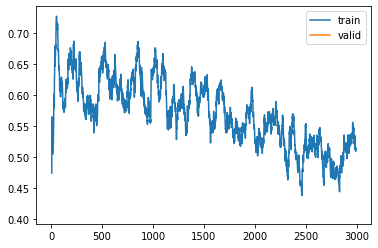

In [12]:
learn.recorder.plot_loss()

SuggestedLRs(lr_min=2.290867705596611e-05, lr_steep=1.3182567499825382e-06)

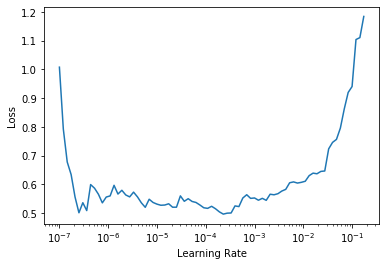

In [28]:
learn.lr_find()

### Now we will unfreeze and will use discriminative learning rate for training

In [29]:
learn.unfreeze()
learn.fit_one_cycle(2, lr_max=slice(1e-6,2e-5))

epoch,train_loss,valid_loss,error_rate,time
0,0.463813,0.390098,0.169395,13:55
1,0.473163,0.379542,0.159372,13:59


* We can go for further training, and we will reduce error rate

### Here we will use Hook functionality, to get the activation maps

In [13]:
class Hook():
    def hook_func(self, m, i, o): self.stored = o.detach().clone()

In [14]:
from pathlib import Path
path = Path.cwd()

In [15]:
path=path/'crack-detection/crack_data/ForLoader/train/cracked/10029.jpg'

In [16]:
path

Path('/home/ec2-user/SageMaker/crack-detection/crack_data/ForLoader/train/cracked/10029.jpg')

In [17]:
img = PILImage.create(path)
x, = first(dls.test_dl([img]))

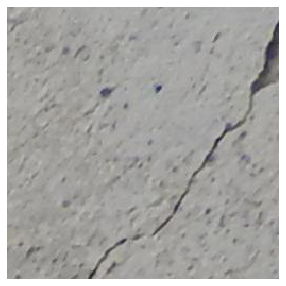

In [71]:
img.show()

In [18]:
x.shape

(1, 3, 256, 256)

In [19]:
learn.model[1][-1].weight.shape

torch.Size([2, 512])

In [30]:
hook_output = Hook()
hook = learn.model[0].register_forward_hook(hook_output.hook_func)

In [31]:
with torch.no_grad(): output = learn.model.eval()(x)

In [32]:
act = hook_output.stored[0]

In [33]:
act.shape

(512, 8, 8)

In [34]:
F.softmax(output, dim=-1)

tensor([[0.6026, 0.3974]], device='cuda:0')

In [35]:
dls.vocab

['cracked', 'uncracked']

In [36]:
cam_map = torch.einsum('ck,kij->cij', learn.model[1][-1].weight, act)
cam_map.shape

torch.Size([2, 8, 8])

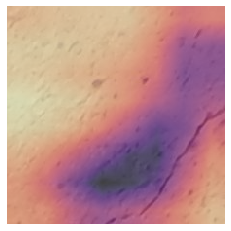

In [44]:
x_dec = TensorImage(dls.train.decode((x,))[0][0])
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map[1].detach().cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');

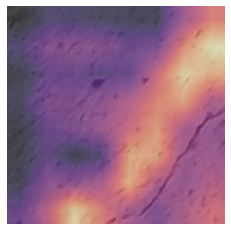

In [27]:
x_dec = TensorImage(dls.train.decode((x,))[0][0])
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map[1].detach().cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');

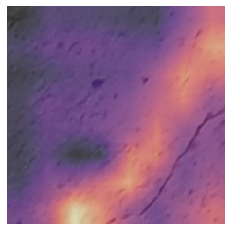

In [37]:
x_dec = TensorImage(dls.train.decode((x,))[0][0])
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map[1].detach().cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');

In [42]:
hook.remove()

In [46]:
class Hook():
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_func)   
    def hook_func(self, m, i, o): self.stored = o.detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

### Now we will look into Grad CAM

In [44]:
class HookBwd():
    def __init__(self, m):
        self.hook = m.register_backward_hook(self.hook_func)   
    def hook_func(self, m, gi, go): self.stored = go[0].detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

In [47]:
cls = 1
with HookBwd(learn.model[0]) as hookg:
    with Hook(learn.model[0]) as hook:
        output = learn.model.eval()(x)
        act = hook.stored
    output[0,cls].backward()
    grad = hookg.stored

In [48]:
w = grad[0].mean(dim=[1,2], keepdim=True)
cam_map = (w * act[0]).sum(0)

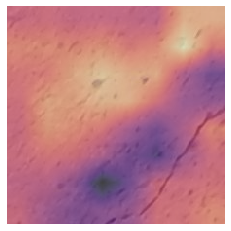

In [49]:
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');

### With Grad CAM ,we can use it on any layer, not specifically last conv layer

In [67]:
learn.model[0][0][-14]


Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [68]:
with HookBwd(learn.model[0][0][-14]) as hookg:
    with Hook(learn.model[0][0][-14]) as hook:
        output = learn.model.eval()(x.cuda())
        act = hook.stored
    output[0,cls].backward()
    grad = hookg.stored

In [69]:
w = grad[0].mean(dim=[1,2], keepdim=True)
cam_map = (w * act[0]).sum(0)

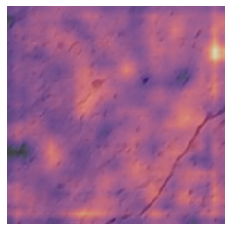

In [70]:
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');